# Visualize the CSH measures

In [25]:
import numpy as np
import pandas as pd
import sys
import glob
import os,time,datetime
from datetime import timedelta, date
from os.path import join

# plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [10,5]
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import matplotlib.patches as patches

import coronadataclass as cdc

import warnings
warnings.filterwarnings("ignore")


## CSH measures

### Read data from various sources

In [26]:
cshmeasures = pd.read_csv('covid19-interventionmeasures/COVID19_non-pharmaceutical-interventions_version2_utf8.csv', delimiter=',',
                         parse_dates=['Date'], dayfirst=True, encoding='ISO-8859–1')

In [27]:
# data on daily case and death numbers
data = cdc.CoronaData(download_data = True)

In [31]:
US_state_data = pd.DataFrame()
us_data_path = '../COVID_infectionrates/data/covid19_US-state-cases/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us/'
files = os.listdir(us_data_path)
files = [f for f in files if f.endswith('csv')]
files.sort()

for f in files:
    df = pd.read_csv(join(us_data_path, f), parse_dates=['Last_Update'], usecols=['Province_State', 'Confirmed', 'Last_Update'])
    df['Date'] = pd.to_datetime(f.split('.csv')[0])
    US_state_data = pd.concat([US_state_data, df])
    
US_state_data.reset_index(drop=True, inplace=True)

In [32]:
# data from Hog Kong, source: https://data.gov.hk/en-data/dataset/hk-dh-chpsebcddr-novel-infectious-agent
hongkongdata = pd.read_csv('../COVID_infectionrates/data/hongkong_casenumbers.csv')#, parse_dates=['Report date'], dayfirst=True)
hongkongdata = hongkongdata.rename(columns={'Report date':'Date'})
hongkongdata['Confirmed'] = 1
hongkongdata = hongkongdata[['Date', 'Confirmed']].groupby(['Date']).sum().reset_index()
hongkongdata['Date'] = pd.to_datetime(hongkongdata['Date'], dayfirst=True)
hongkongdata = hongkongdata.sort_values('Date')
hongkongdata['Confirmed'] = hongkongdata['Confirmed'].cumsum()

### Plotting functions

In [33]:
def PlotDataTimeSeries(data, ax, color):
    # set up date x-ticks
    ax.xaxis.set_major_locator(weeks)
    ax.xaxis.set_major_formatter(date_fmt)
    ax.xaxis.set_minor_locator(days)
    ax.format_xdata = mdates.DateFormatter('%y %m %d')
    data = data.reset_index(drop=True).copy()
    
    # split data into before and after split_threshold cases
    split_threshold = 50
    manycases = data[data['Confirmed'] >= split_threshold]
    sepindex = manycases.index[0]
    fewcases = data.loc[0:sepindex + 1]
    manycases = data.loc[sepindex:]

    # timeseries after >= 50 cases have been reached
    #infectionmeasure = np.diff(np.log(manycases['Confirmed']))
    #infectionmeasure = (manycases['Confirmed'][1:].values / manycases['Confirmed'][0:-1].values - 1) * 100
    infectionmeasure = manycases['Confirmed'][1:].values - manycases['Confirmed'][0:-1].values
    
    try:
        dates = [datetime.datetime.strptime(a,'%m/%d/%y') for a in np.array(manycases['Date'])[1:]]
    except:
        dates = manycases['Date'][1:].values
        
    ax.plot(dates, infectionmeasure, marker = 'o', c = color, 
            label = 'confirmed cases >= {}'.format(split_threshold), lw = 2, markersize = 8, alpha = .35)

    # timeseries before 50 cases have been reached
    #infectionmeasure = np.diff(np.log(fewcases['Confirmed']))
    #infectionmeasure = (fewcases['Confirmed'][1:].values / fewcases['Confirmed'][0:-1].values - 1) * 100
    infectionmeasure = fewcases['Confirmed'][1:].values - fewcases['Confirmed'][0:-1].values
    try:
        dates = [datetime.datetime.strptime(a,'%m/%d/%y') for a in np.array(fewcases['Date'])[1:]]
    except:
        dates = fewcases['Date'][1:].values

    ax.plot(dates, infectionmeasure, marker = 'x', c = color, 
            label = 'confirmed cases < {}'.format(split_threshold), lw = 2, markersize = 8, alpha = .15)

    # legend
    legend = ax.legend(loc=7, fontsize=8)
    ymax = ax.get_ylim()[1]
    return legend, ymax

In [34]:
def PlotSelectedMeasures(data, ax, ymax):
    shift = 0
    measure_date_cuoff = date(2020,1,20)
    data = data.reset_index(drop=True)
    N_measures = len(data)
    fsize = 2
    if N_measures < 10:
        fsize=10
    if N_measures < 15:
        fsize=9
    if N_measures < 20:
        fsize=8
    if N_measures < 25:
        fsize=7
    if N_measures < 30:
        fsize=6
    if N_measures < 35:
        fsize=5
    if N_measures < 40:
        fsize=4
    if N_measures < 45:
        fsize=3
    data = data.sort_values('Date')
    data = data.reset_index(drop=True)
    for k, row in data.iterrows():
        mdate = row['Date']
        if mdate < measure_date_cuoff:
            continue
        #print(row)
        measure_color = measure_color_codes[row['Measure_L1']]
        if row['Measure_L3'] != row['Measure_L3']: # nan-check
            measuretext = row['Measure_L2']
        #elif (row['Measure_L4'] != row['Measure_L4']) and (row['Measure_L3'] != row['Measure_L3']):
        #    measuretext = row['Measure_L3'] + '_' + row['Measure_L4']
        else:
            measuretext = row['Measure_L2'] + ': ' + row['Measure_L3']
        if measuretext != measuretext:
            continue
        if len(measuretext) > 100:
            measuretext = measuretext[0:100] + '...'
        textlevel = ymax * 0.1 + k * ((ymax - ymax * 0.1) / N_measures)
        ax.plot([mdate + timedelta(days=shift), mdate + timedelta(days=shift)], [0,ymax + 0.1*ymax], 
                '--', color=measure_color, lw=0.5, alpha=1, dashes=(5,10))
        ax.text(mdate + timedelta(days=shift+0.5), textlevel, measuretext, fontsize=fsize, color=measure_color)

    custom_lines = [Line2D([0], [0], color=measure_color_codes[measure], lw=2)
                   for measure in data['Measure_L1'].unique()]

    legend2 = ax.legend(custom_lines, data['Measure_L1'].unique(),
                        loc='best', fontsize=8)
    return legend2

In [35]:
def MakePlot(country, countrydata, countrymeasures, color, j):
    fig, ax = plt.subplots(figsize=(10, 4.5))
    legend1, ymax = PlotDataTimeSeries(countrydata, ax, color)

    legend2 = PlotSelectedMeasures(countrymeasures, ax, ymax)
    ax.add_artist(legend1)
    ax.add_artist(legend2)

    ax.tick_params(labelrotation=90, labelsize=8)
    ax.set_title(country, fontsize = 20)
    ax.set_ylim([- 0.05* ymax, 0.1*ymax + ymax])
    ax.set_xlim([datetime.datetime.strptime('1/20/20','%m/%d/%y'), datetime.datetime.strptime('07/09/20','%m/%d/%y')])
    #ax.set_ylabel('daily increase %')
    ax.set_ylabel('daily new cases')
    #ax.grid()

    fig.tight_layout()
    plt.savefig('results/measure_overview_CSH_{}_{}.svg'.format(country, j+1))
    plt.savefig('results/measure_overview_CSH_{}_{}.pdf'.format(country, j+1))

    plt.show()


### Measure splits

In [36]:
cshmeasures = cshmeasures.replace({'Federation of Bosnia and Herzegovina':'Bosnia and Herzegovina'})

In [37]:
measures1 = cshmeasures[(cshmeasures['Measure_L1'] == 'Case identification, contact tracing and related measures')\
                                   | (cshmeasures['Measure_L1'] == 'Travel restriction') \
                                   | (cshmeasures['Measure_L1'] == 'Social distancing')]
measures2 = cshmeasures[(cshmeasures['Measure_L1'] == 'Risk communication')\
                                   | (cshmeasures['Measure_L1'] == 'Healthcare and public health capacity') \
                                   | (cshmeasures['Measure_L1'] == 'Resource allocation')]
measures3 = cshmeasures[cshmeasures['Measure_L1'] == 'Returning to normal life']
measuredata = [measures1, measures2, measures3]

In [38]:
measure_color_codes = {'Case identification, contact tracing and related measures':'Green',
                       'Travel restriction':'MediumBlue', 
                       'Social distancing':'FireBrick',
                       'Risk communication':'DarkOrange',
                       'Healthcare and public health capacity':'HotPink', 
                       'Resource allocation':'DarkCyan',
                       'Returning to normal life':'black'}

In [39]:
specialcountries = {'Albania':'Albania', # OK
                    'Austria':'Austria', # OK
                    'Belgium':'Belgium', # OK
                    'Bosnia and Herzegovina':'Bosnia and Herzegovina', # OK
                    'Brazil':'Brazil', # OK
                    'Canada':'Canada', # OK
                    'China':'China', # -> only Hong Kong, special data
                    'Croatia':'Croatia', # OK
                    'Czechia': 'Czech Republic', # OK
                    'Denmark':'Denmark', # OK
                    'Diamond Princess':'Diamond Princess',
                    'Ecuador':'Ecuador', # OK
                    'El Salvador':'El Salvador', # OK
                    'Estonia':'Estonia', # OK
                    'Finland':'Finland', # OK
                    'France':'France', # OK
                    'Germany':'Germany', # OK
                    'Ghana':'Ghana', # OK
                    'Greece':'Greece', # OK
                    'Honduras':'Honduras', # OK
                    'Hungary':'Hungary', # OK
                    'Iceland':'Iceland', # OK
                    'India':'India', # OK
                    'Indonesia':'Indonesia', # OK
                    'Italy':'Italy', # OK
                    'Japan':'Japan', # OK
                    'Kazakhstan':'Kazakhstan', # OK
                    'Kosovo':'Kosovo', # OK
                    'Kuwait':'Kuwait', # OK
                    'Liechtenstein':'Liechtenstein', # OK
                    'Lithuania':'Lithuania', # OK
                    'Malaysia':'Malaysia', # OK
                    'Mauritius':'Mauritius', # OK
                    'Mexico':'Mexico', # OK
                    'Montenegro':'Montenegro', # OK
                    'Netherlands':'Netherlands', # OK
                    'New Zealand':'New Zealand', # OK
                    'North Macedonia':'North Macedonia',
                    'Norway':'Norway', # OK
                    'Poland':'Poland', # OK
                    'Portugal':'Portugal', # OK
                    'Ireland':'Republic of Ireland', # OK
                    'Romania':'Romania', # OK
                    'Serbia':'Serbia', # OK
                    'Singapore':'Singapore', # OK
                    'Slovakia':'Slovakia', # OK
                    'Slovenia':'Slovenia', # OK
                    'Korea, South':'South Korea', # OK
                    'Senegal':'Senegal', # OK
                    'Spain':'Spain', # OK
                    'Sweden':'Sweden', # Ok
                    'Switzerland':'Switzerland', # OK
                    'Syria':'Syria', # OK
                    'Taiwan*':'Taiwan', # OK
                    'Thailand':'Thailand', # OK
                    'United Kingdom':'United Kingdom', # Ok
                    'US':'United States of America' # OK - special case for states, special data
                    }

# Honkkong data from this source: https://data.gov.hk/en-data/dataset/hk-dh-chpsebcddr-novel-infectious-agent and plotted with sep_threshold = 30

In [40]:
cshmeasures['Country'].unique()

array(['Albania', 'Austria', 'Belgium', 'Bosnia and Herzegovina',
       'Brazil', 'Canada', 'China', 'Croatia', 'Czech Republic',
       'Denmark', 'Diamond Princess', 'Ecuador', 'El Salvador', 'Estonia',
       'Finland', 'France', 'Germany', 'Ghana', 'Greece', 'Honduras',
       'Hungary', 'Iceland', 'India', 'Indonesia', 'Italy', 'Japan',
       'Kazakhstan', 'Kosovo', 'Kuwait', 'Liechtenstein', 'Lithuania',
       'Malaysia', 'Mauritius', 'Mexico', 'Montenegro', 'Netherlands',
       'New Zealand', 'North Macedonia', 'Norway', 'Poland', 'Portugal',
       'Republic of Ireland', 'Romania', 'Senegal', 'Serbia', 'Singapore',
       'Slovakia', 'Slovenia', 'South Korea', 'Spain', 'Sweden',
       'Switzerland', 'Syria', 'Taiwan', 'Thailand', 'United Kingdom',
       'United States of America'], dtype=object)

In [41]:
#for country, countrydata in data:
#    print(country)

United Kingdom


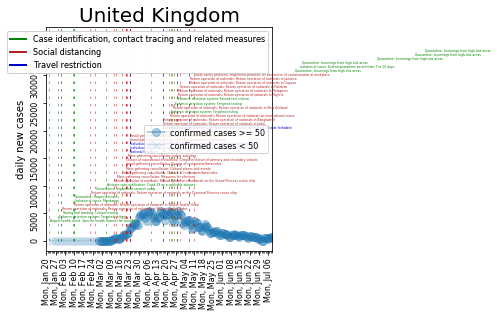

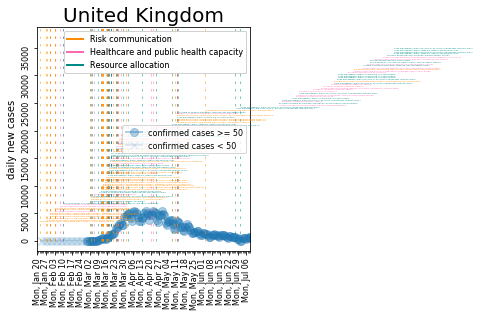

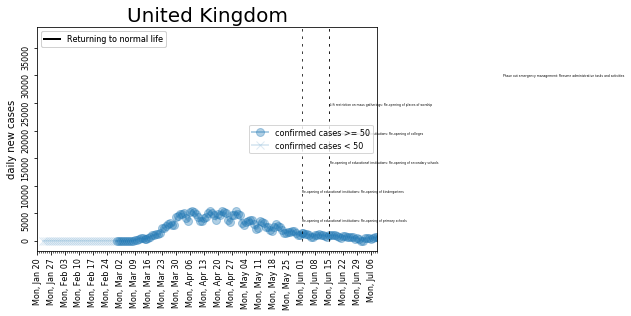

In [43]:
specialcountries = {'United Kingdom':'United Kingdom'}

days     = mdates.DayLocator()
weeks    = mdates.WeekdayLocator(byweekday = mdates.MO)
date_fmt = mdates.DateFormatter('%a, %b %d')
colornames       = [cn for cn in matplotlib.colors.TABLEAU_COLORS.keys() if (cn.upper() != 'TAB:WHITE' and cn.upper() != 'TAB:GRAY')]

for country, countrydata in data:
    if country in specialcountries.keys():
        print(country)
        color = colornames[0]
        
        # for the US we plot every state separately
        if country == 'US':
            csh_states = cshmeasures[cshmeasures['Country'] == 'United States of America']['State'].unique()
            for state in csh_states:
                if state != 'United States of America': # do not plot measures for all of the US
                    countrydata = US_state_data[US_state_data['Province_State'] == state]
                    countrydata = countrydata.sort_values(by='Date', ascending=True)

                    for j, mdata in enumerate(measuredata):
                        countrymeasures = mdata[mdata['State'] == state].copy()
                        if len(countrymeasures) > 0:
                            MakePlot(state, countrydata, countrymeasures, color, j)
                        else:
                            print('No measures detected for country {} measures split {}'.format(country, j))

        # for China there is only the region Hong Kong - we use special data to plot the measures there
        elif country == 'China':
            countrydata = hongkongdata
            for j, mdata in enumerate(measuredata):
                countrymeasures = mdata[mdata['Region'] == 'Hong Kong'].copy()
                if len(countrymeasures) > 0:
                    MakePlot('Hong Kong', countrydata, countrymeasures, color, j)
                else:
                        print('No measures detected for country {} measures split {}'.format(country, j))
                
        else:
            for j, mdata in enumerate(measuredata):
                countrymeasures = mdata[mdata['Country'] == specialcountries[country]].copy()
                # drop all measures that are not country-wide
                countrymeasures = countrymeasures[countrymeasures['Region'] == specialcountries[country]]
                if len(countrymeasures) > 0:
                    MakePlot(country, countrydata, countrymeasures, color, j)
                else:
                        print('No measures detected for country {} measures split {}'.format(country, j))
            
plt.show()